In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from matplotlib.pyplot import figure

filename = 'Desktop\AAPL (3).csv'

df = pd.read_csv(filename)

df.sort_values('Date')

df.tail(10)

Using TensorFlow backend.


,Date,Open,High,Low,Close,Adj Close,Volume
4517,2018-08-31,226.509995,228.869995,226.000000,227.630005,227.630005,43340100
4518,2018-09-04,228.410004,229.179993,226.630005,228.360001,228.360001,27390100
4519,2018-09-05,228.990005,229.669998,225.100006,226.869995,226.869995,33333000
4520,2018-09-06,226.229996,227.350006,221.300003,223.100006,223.100006,34290000
4521,2018-09-07,221.850006,225.369995,220.710007,221.300003,221.300003,37619800
4522,2018-09-10,220.949997,221.850006,216.470001,218.330002,218.330002,39516500
4523,2018-09-11,218.009995,224.300003,216.559998,223.850006,223.850006,35749000
4524,2018-09-12,224.940002,225.000000,219.839996,221.070007,221.070007,49278700
4525,2018-09-13,223.520004,228.350006,222.570007,226.410004,226.410004,41706400
4526,2018-09-14,225.750000,226.839996,222.520004,223.839996,223.839996,31902700


In [2]:
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
open_prices = df.loc[:,'Open'].as_matrix()
close_prices = df.loc[:,'Close'].as_matrix()
OHLC_mean = (high_prices+low_prices+open_prices+close_prices)/4.0

print(OHLC_mean)

[  4.13783425   4.263393     4.29380375 ... 222.71250125 225.21250525
 224.737499  ]


C:\Users\Yi Rong\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\Yi Rong\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Yi Rong\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yi Rong\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [3]:
df['OHLC Mean'] = OHLC_mean
df = df.drop(columns=['Date','Open', 'High','Low', 'Close','Adj Close', 'Volume'])
df.head(5)

,OHLC Mean
0,4.137834
1,4.263393
2,4.293804
3,4.108259
4,3.659598


In [4]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [6]:
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [7]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [8]:
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

In [9]:
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
 

In [10]:
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

In [11]:
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

In [12]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

In [13]:
def plot_forecasts(series, forecasts, n_test):
    figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
    # plot the entire dataset in blue
    pyplot.plot(series.values[4400:])
    
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range (off_s - 4400, off_e-4400)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()
    

In [14]:
# load dataset
series = df
n_lag = 1
n_seq = 30
n_test = 120
n_epochs = 20
n_batch = 1
n_neurons = 1


In [15]:
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)



C:\Users\Yi Rong\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
X, y = train[:, 0:n_lag], train[:, n_lag:]
X = X.reshape(X.shape[0], 1, X.shape[1])
# design network
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
for i in range(n_epochs):
    model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
    model.reset_states()
    


Epoch 1/1
4376/4376 [==============================] - 27s 6ms/step - loss: 0.0092
Epoch 1/1
4376/4376 [==============================] - 38s 9ms/step - loss: 0.0092
Epoch 1/1
4376/4376 [==============================] - 27s 6ms/step - loss: 0.0092
Epoch 1/1
4376/4376 [==============================] - 27s 6ms/step - loss: 0.0092
Epoch 1/1
4376/4376 [==============================] - 27s 6ms/step - loss: 0.0091
Epoch 1/1
4376/4376 [==============================] - 28s 6ms/step - loss: 0.0091
Epoch 1/1
4376/4376 [==============================] - 27s 6ms/step - loss: 0.0091
Epoch 1/1
4376/4376 [==============================] - 28s 6ms/step - loss: 0.0091
Epoch 1/1
4376/4376 [==============================] - 27s 6ms/step - loss: 0.0091
Epoch 1/1
4376/4376 [==============================] - 28s 6ms/step - loss: 0.0091
Epoch 1/1
4376/4376 [==============================] - 27s 6ms/step - loss: 0.0091
Epoch 1/1
4376/4376 [==============================] - 28s 6ms/step - loss: 0.0091
Epoc

In [26]:
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)


In [27]:
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test)


In [28]:
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)


t+1 RMSE: 2.133916
t+2 RMSE: 3.568895
t+3 RMSE: 4.669362
t+4 RMSE: 5.526738
t+5 RMSE: 6.288922
t+6 RMSE: 6.967098
t+7 RMSE: 7.660947
t+8 RMSE: 8.275357
t+9 RMSE: 8.710122
t+10 RMSE: 8.995579
t+11 RMSE: 9.242450
t+12 RMSE: 9.490179
t+13 RMSE: 9.736468
t+14 RMSE: 9.952501
t+15 RMSE: 10.133733
t+16 RMSE: 10.307961
t+17 RMSE: 10.560417
t+18 RMSE: 10.859161
t+19 RMSE: 11.155123
t+20 RMSE: 11.525401
t+21 RMSE: 11.953159
t+22 RMSE: 12.474703
t+23 RMSE: 12.988871
t+24 RMSE: 13.430750
t+25 RMSE: 13.833378
t+26 RMSE: 14.193071
t+27 RMSE: 14.544495
t+28 RMSE: 14.872183
t+29 RMSE: 15.203776
t+30 RMSE: 15.491338


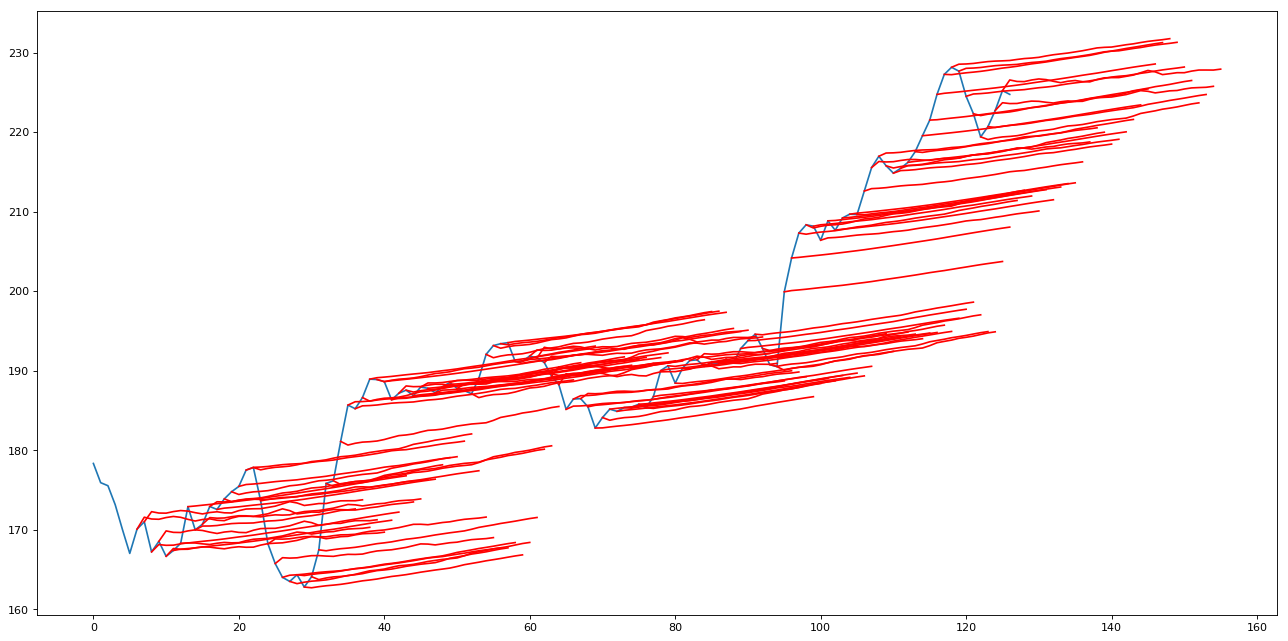

In [29]:
# plot forecasts
plot_forecasts(series, forecasts, n_test)